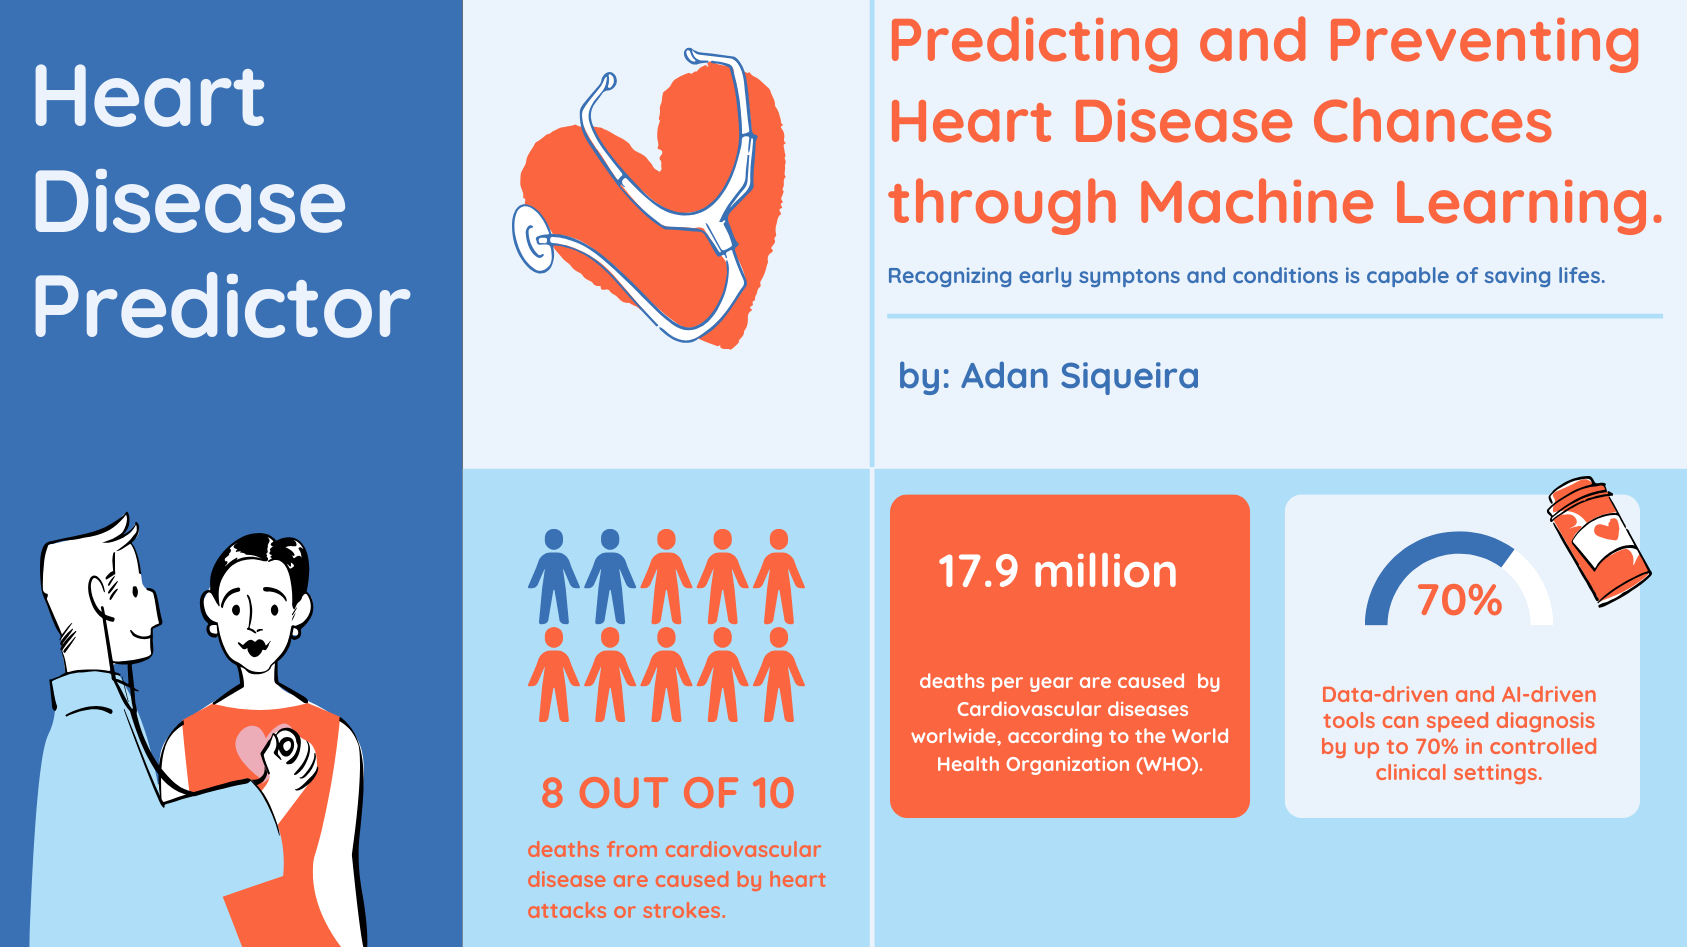

# **DATA OVERVIEW**

The dataset used in this project is the **Heart Disease** dataset from the UCI Machine Learning Repository https://archive.ics.uci.edu/dataset/45/heart+disease, derived from angiographic results of 303 patients at the Cleveland Clinic Foundation, Ohio.

Although the full dataset contains 76 features, a subset of **14 variables** is commonly used in machine learning research and was selected here. The data was originally collected from patient exams at the **Cleveland Clinic Foundation (USA)**.

All patient data is anonymized, with no names or personal identifiers.

# **CONTEXT**

Cardiovascular diseases remain the leading cause of death worldwide, accounting for about one-third of all global deaths, according to the World Health Organization. Early diagnosis and timely intervention are critical for reducing complications and saving lives. In this context, applying Machine Learning techniques can offer intelligent support to clinical decision-making by identifying patterns in historical clinical data that point to higher or lower risk of heart disease.



### **PROBLEM STATEMENT**

Identifying patients at high risk of heart disease still relies on a combination of clinical exams, lab tests, and often invasive procedures. This can delay diagnosis or make it unfeasible in resource-limited settings. Moreover, traditional medical evaluation does not always consider the complex interaction of multiple clinical variables. Therefore, we aim to build a tool that can **automatically detect risk patterns** from structured data, providing fast and interpretable predictions.



### **OBJECTIVE**

The goal of this project is to build a **predictive model for heart disease risk** using **structured clinical data** from patients, and to deploy it through an **interactive dashboard**. The application enables any user — whether a healthcare professional or data science enthusiast — to enter clinical data and receive an automated prediction about the presence or absence of heart disease.



### **TASKS**

To achieve this, the following steps were performed:

1. **Data acquisition** using the `ucimlrepo` API, directly from the UCI repository.  
2. **Exploratory data analysis (EDA)**: handling missing values, variable inspection, statistical summaries, and visualization.  
3. **Feature engineering**: normalization, encoding categorical features.  
4. **Model training**: experimentation with various classification algorithms.  
5. **Hyperparameter tuning** using Bayesian Optimization (`BayesSearchCV`).  
6. **Robust evaluation** through nested cross-validation.  
7. **Model deployment** as a web application using Dash, with an interactive prediction form and data exploration interface.


### **DATA STRUCTURE**

Below is a summary of the 14 selected variables:

| Variable    | Type       | Description                                                             | Category        | Missing Values |
|-------------|------------|-------------------------------------------------------------------------|-----------------|----------------|
| `age`       | Numerical  | Patient's age (in years)                                                | Demographic     | No             |
| `sex`       | Categorical| Sex (1 = male, 0 = female)                                              | Demographic     | No             |
| `cp`        | Categorical| Chest pain type                                                         | Clinical        | No             |
| `trestbps`  | Numerical  | Resting blood pressure (on admission) (mm Hg)                           | Clinical        | No             |
| `chol`      | Numerical  | Serum cholesterol (mg/dL)                                               | Clinical        | No             |
| `fbs`       | Categorical| Fasting blood sugar > 120 mg/dL (1 = true, 0 = false)                   | Lab             | No             |
| `restecg`   | Categorical| Resting electrocardiogram results   (0: Normal ; 1: Having ST-T wave abnormality ; 2: Showing probable or definite left ventricular hypertrophy by Estes criteria)                                    | Clinical        | No             |
| `thalach`   | Numerical  | Maximum heart rate achieved                                             | Clinical        | No             |
| `exang`     | Categorical| Exercise-induced angina (1 = yes, 0 = no)                               | Clinical        | No             |
| `oldpeak`   | Numerical  | ST depression induced by exercise relative to rest (mm)                     | Clinical        | No             |
| `slope`     | Categorical| Slope of the ST segment during peak exercise                           | Clinical        | No             |
| `ca`        | Categorical  | Number of major vessels (0–3) colored by fluoroscopy                   | Clinical        | **Yes**        |
| `thal`      | Categorical| Type of thalassemia defect (normal, fixed, reversible)                 | Clinical        | **Yes**        |
| `num`       | Target     | Heart disease diagnosis (0 = no, 1–4 = presence of disease)             | Target Variable | No             |

The variables with missing values (`ca` and `thal`) were handled appropriately during preprocessing, using imputation techniques to ensure the data remained reliable for training the model.

The **"goal" field refers to the presence of heart disease in the patient**. It is integer value **from 0 (no presence) to 4**.

Experiments with the Cleveland database have concentrated on simply attempting to distinguish presence (values 1,2,3,4) from absence (value 0).





# **1. Importing Libraries**
The following libraries were imported for data treatment and predictive model's development:

In [ ]:
!pip install ucimlrepo

In [ ]:
!pip install scikit-optimize

In [108]:
#Data Collecting
from ucimlrepo import fetch_ucirepo

#Data Analysis, manipulation and visualizations
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt
import seaborn as sns
import json
import nbformat

#Machine Learning Model's Development
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, make_scorer, recall_score
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline, make_pipeline
from skopt import BayesSearchCV
from skopt.space import Real, Categorical, Integer
import xgboost as xgb

#Final Model's export
import joblib

# **2.Collecting Data**

In [3]:
heart_disease = fetch_ucirepo(id=45)

In [4]:
# data (as pandas dataframes)
heart_disease = fetch_ucirepo(id=45)
df = pd.DataFrame(heart_disease['data']['features'])
df['ill'] = heart_disease['data']['targets']

The target variable `num` represents the presence of heart disease, ranging from 0 (no disease) to 4 (confirmed disease). For binary classification, we consider any value greater than zero as an indication of heart disease (i.e., target = 1 if num > 0).

In [5]:
df['ill'] = (df['ill'] > 0).astype(int)

In [6]:
df.head()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,ill
0,63,1,1,145,233,1,2,150,0,2.3,3,0.0,6.0,0
1,67,1,4,160,286,0,2,108,1,1.5,2,3.0,3.0,1
2,67,1,4,120,229,0,2,129,1,2.6,2,2.0,7.0,1
3,37,1,3,130,250,0,0,187,0,3.5,3,0.0,3.0,0
4,41,0,2,130,204,0,2,172,0,1.4,1,0.0,3.0,0


# **3. Cleaning Data - Handling Missing Values and Duplicated Registers**

During exploration, there were no duplicated registers found. However, we found **missing values in two variables**: `ca` and `thal`, accounting for approximately 2% of the dataset (6 records). Considering:

- The **low proportion of missing data** (Their removal does not compromise the statistical representativeness or the model's learning capacity)
- The **clinical relevance** of the affected features? `ca` (number of vessels colored by fluoroscopy) and `thal` (type of thalassemia) are strongly associated with the presence of heart disease. Filling in these values artificially could contaminate both the predictive and clinical quality of the model.
- And the risk of introducing bias by artificial imputation and compromise the clinical integrity of the dataset.

I've choosen:
- **remove rows with missing values** (`dropna()`), ensuring cleaner data and simplifying the modeling pipeline.


In [7]:
df.duplicated().unique()

array([False])

In [8]:
df.isnull().sum()

,0
age,0
sex,0
cp,0
trestbps,0
chol,0
fbs,0
restecg,0
thalach,0
exang,0
oldpeak,0


In [9]:
df.query('ca.isnull()')

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,ill
166,52,1,3,138,223,0,0,169,0,0.0,1,NaN,3.0,0
192,43,1,4,132,247,1,2,143,1,0.1,2,NaN,7.0,1
287,58,1,2,125,220,0,0,144,0,0.4,2,NaN,7.0,0
302,38,1,3,138,175,0,0,173,0,0.0,1,NaN,3.0,0


In [10]:
df.query('thal.isnull()')

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,ill
87,53,0,3,128,216,0,2,115,0,0.0,1,0.0,NaN,0
266,52,1,4,128,204,1,0,156,1,1.0,2,0.0,NaN,1


In [11]:
df = df.dropna()

In [12]:
df.shape

(297, 14)

In [13]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 297 entries, 0 to 301
Data columns (total 14 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       297 non-null    int64  
 1   sex       297 non-null    int64  
 2   cp        297 non-null    int64  
 3   trestbps  297 non-null    int64  
 4   chol      297 non-null    int64  
 5   fbs       297 non-null    int64  
 6   restecg   297 non-null    int64  
 7   thalach   297 non-null    int64  
 8   exang     297 non-null    int64  
 9   oldpeak   297 non-null    float64
 10  slope     297 non-null    int64  
 11  ca        297 non-null    float64
 12  thal      297 non-null    float64
 13  ill       297 non-null    int64  
dtypes: float64(3), int64(11)
memory usage: 34.8 KB


# **4. Exploratory Data Analysis and Data Treatment**
Before building any predictive model, it is essential to ensure that the dataset is in appropriate condition to feed machine learning algorithms. The quality of the data directly impacts the model's **accuracy, robustness, and interpretability**. During the initial exploration and preparation phase, we applied a series of procedures to understand the data structure, identify patterns, prevent distortions, and optimize model performance.

##**❤️ 4.1 Features and Target Variable Behavior**

The goal of the model is to predict the `target` variable, indicating the **presence or absence of heart disease**. Therefore, we analyzed **under what conditions the disease occurs or does not occur**, by:


- Checking **statistical distributions** (mean, median, standard deviation, skewness)
- Understanding the **distribution of the target class**: is it balanced or imbalanced?
- Exploring **statistical relationships between features and outcome**
- Identifying **specific patient groups more prone to developing heart disease**
- Understanding each feature’s **variability in relation to the target variable**

This step is essential to investigate relevant clinical patterns and guide appropriate preprocessing strategies (e.g., binarization, normalization, log transformation).

In [14]:
df['ill'].value_counts(normalize = True)

,proportion
ill,
0,0.538721
1,0.461279


In [15]:
continuos_cols = ['age', 'trestbps', 'chol', 'thalach', 'oldpeak']
categorical_cols = ['sex', 'cp', 'fbs', 'restecg', 'exang', 'slope', 'thal']

## Continuous Variables

In [16]:
df[continuos_cols].describe()

,age,trestbps,chol,thalach,oldpeak
count,297.000000,297.000000,297.000000,297.000000,297.000000
mean,54.542088,131.693603,247.350168,149.599327,1.055556
std,9.049736,17.762806,51.997583,22.941562,1.166123
min,29.000000,94.000000,126.000000,71.000000,0.000000
25%,48.000000,120.000000,211.000000,133.000000,0.000000
50%,56.000000,130.000000,243.000000,153.000000,0.800000
75%,61.000000,140.000000,276.000000,166.000000,1.600000
max,77.000000,200.000000,564.000000,202.000000,6.200000


In [17]:
df['chol'].describe()

,chol
count,297.000000
mean,247.350168
std,51.997583
min,126.000000
25%,211.000000
50%,243.000000
75%,276.000000
max,564.000000


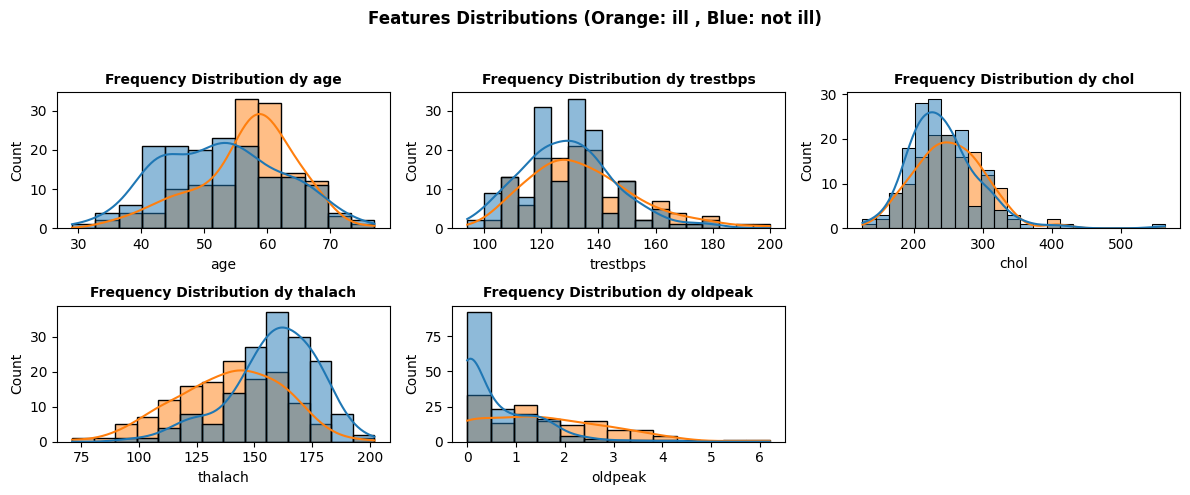

In [18]:
n = len(continuos_cols)
ncols = 3
nrows = math.ceil(n / ncols)
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(12, 5))
axes = axes.flatten()
for i, col in enumerate(continuos_cols):
  ax = axes[i]
  sns.histplot(data=df, x=col, kde = True, hue = 'ill', ax = ax)
  ax.set_title(f'Frequency Distribution dy {col}', fontweight = 'bold', fontsize = 10)
  ax.get_legend().remove()
fig.delaxes(axes[-1])
fig.suptitle('Features Distributions (Orange: ill , Blue: not ill)', fontsize=12, fontweight='bold')
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

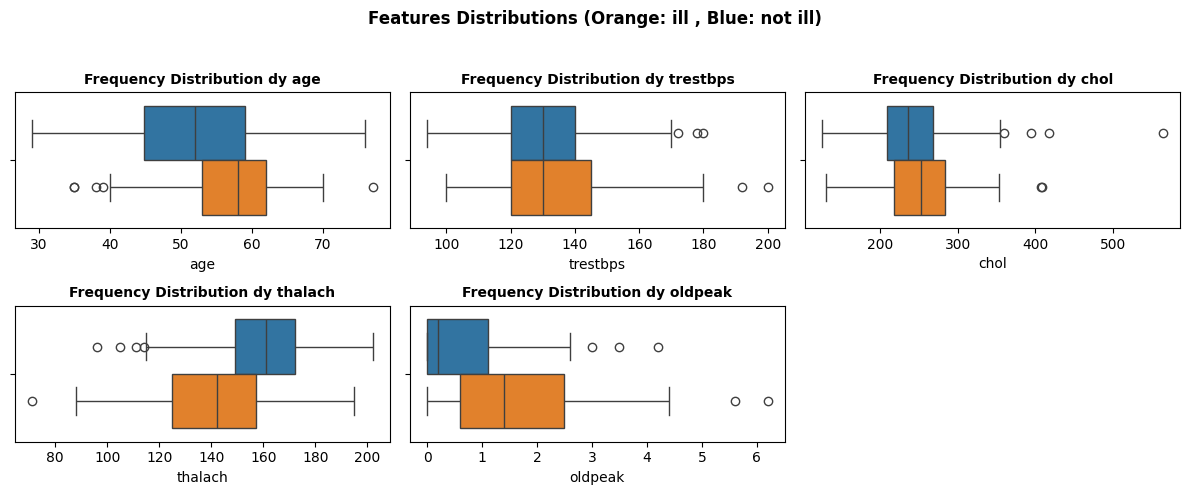

In [19]:
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(12, 5))
axes = axes.flatten()
for i, col in enumerate(continuos_cols):
  ax = axes[i]
  sns.boxplot(data=df, x=col, hue = 'ill', ax = ax)
  ax.set_title(f'Frequency Distribution dy {col}', fontweight = 'bold', fontsize = 10)
  ax.get_legend().remove()
fig.delaxes(axes[-1])
fig.suptitle('Features Distributions (Orange: ill , Blue: not ill)', fontsize=12, fontweight='bold')
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

## Categoric Variables

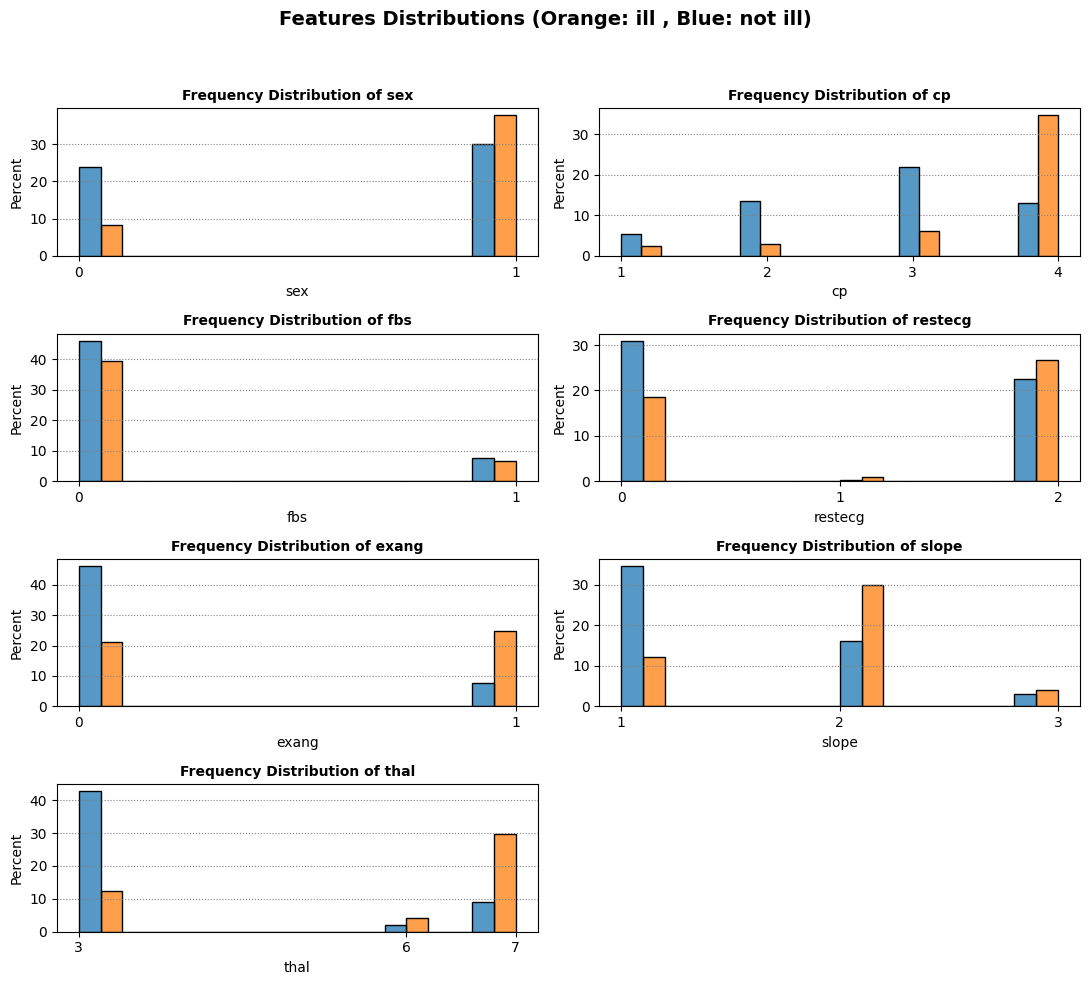

In [20]:
n = len(categorical_cols)
ncols = 2
nrows = math.ceil(n / ncols)
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(11, 10))
axes = axes.flatten()
for i, col in enumerate(categorical_cols):
    ax = axes[i]
    sns.histplot(data=df, x=col, stat='percent', hue='ill', multiple='dodge', ax=ax)
    ax.set_title(f'Frequency Distribution of {col}', fontweight='bold', fontsize=10)
    unique_vals = sorted(df[col].dropna().unique())
    ax.set_xticks(unique_vals)
    ax.grid(axis='y', linestyle=':', color='gray')
    ax.get_legend().remove()
fig.delaxes(axes[-1])
fig.suptitle('Features Distributions (Orange: ill , Blue: not ill)', fontsize=14, fontweight='bold')
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

## **⚕️4.2 Outliers Detection in a Clinical Binary Classification Context**

Outliers can appear due to data entry errors, incorrect measurements or natural variability. They may:

- Skew **central tendency metrics** (mean, std deviation)
- Disproportionately influence scale-sensitive algorithms (e.g., logistic regression, SVM)
- Introduce **bias** into the training process

However, in medical predictive modeling, outliers are not just statistical anomalies — they may reflect rare conditions, measurement errors, or labeling inconsistencies. Therefore, their treatment must be carefully aligned with clinical knowledge and diagnostic logic.

In this project, we are building a binary classification model to predict the presence (ill = 1) or absence (ill = 0) of heart disease. Therefore, we define outliers relative to the target label.

- If a patient's features present clinically abnormal values (extremely high), but the label is ill = 0 (not ill), this record may be considered a clinical outlier.

- If a patient's features are abnormal and the label is ill = 1, then the record is likely clinically consistent, not an outlier.

This approach aligns with the objective of the model: to learn patterns that are clinically grounded, not biased by mislabeling or noise.

Below are the criteria used to define clinical outliers, based on internationally recognized medical guidelines:

| Feature                                | Threshold        | Source                                                                                                                                             |
|----------------------------------------|------------------|----------------------------------------------------------------------------------------------------------------------------------------------------|
| **trestbps** (Resting blood pressure)  | ≥ 168 mmHg       | [ACC/AHA 2017 Hypertension Guidelines](https://www.ahajournals.org/doi/10.1161/HYP.0000000000000065) — Stage 2 hypertension begins at 140 mmHg; 168 is used as a high-risk marker |
| **chol** (Serum cholesterol)           | ≥ 300 mg/dL      | [NCEP ATP III](https://www.nhlbi.nih.gov/files/docs/guidelines/atp3xsum.pdf) — Cholesterol > 240 is considered high; > 300 is rare and associated with severe hyperlipidemia       |
| **oldpeak** (ST depression)            | ≥ 2.5 mm         | [Cleveland Clinic](https://my.clevelandclinic.org/health/diagnostics/16989-stress-test) — ST depression > 2 mm is clinically significant and strongly suggestive of ischemia        |

The function below flags patients who meet at least two of the three high-risk conditions listed above while being labeled as ill = 0:

In [21]:
def find_clinical_outliers(df):
    condition_trestbps = df['trestbps'] >= 168
    condition_chol = df['chol'] >= 300
    super_high_chol = df['chol'] >= 500
    condition_oldpeak = df['oldpeak'] >= 2.5
    super_high_oldpeak = df['oldpeak'] >= 4
    condition_not_ill = df['ill'] == 0
    #Count how many risk conditions each patient satisfies
    risk_conditions = (condition_trestbps.astype(int) +
                       condition_chol.astype(int) +
                       condition_oldpeak.astype(int) +
                       super_high_chol.astype(int) +
                       super_high_oldpeak.astype(int))
    #Flag as outliers: patients with 2 or more conditions and labeled as not ill
    outliers = df[(risk_conditions >= 2) & condition_not_ill]
    return outliers

In [22]:
find_clinical_outliers(df)

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,ill
152,67,0,3,115,564,0,2,160,0,1.6,2,0.0,7.0,0
183,59,1,1,178,270,0,2,145,0,4.2,3,0.0,7.0,0
201,64,0,4,180,325,0,0,154,1,0.0,1,0.0,3.0,0


Given the binary classification task (predicting presence or absence of heart disease), and the fact that these 3 records present **multiple high-risk features** but a **negative label**, they represent an **atypical pattern** that could:
- Confuse the model during training
- Bias evaluation metrics
- Obscure true clinical relationships

There is a small chance that these 3 patients represent valid but rare cases. However, given the fact it represents a fairly small piece of data and removing them ensures better **alignment between labels and feature patterns**, while preserving the dataset’s **representativeness** and **clinical credibility**:

> **We chose to remove only the 3 most inconsistent records (those with ≥ 2 high-risk clinical features but labeled as `not ill`)** to improve model learning while preserving medical integrity and statistical robustness.

In [23]:
df.drop(find_clinical_outliers(df).index, inplace=True)

## 🔗 **4.3 Correlation Between Features**

High correlation between predictor variables (multicollinearity) can degrade model performance by:

- Introducing **redundant information**
- Leading to **overfitting**, reducing generalization to new data
- Distorting coefficients in linear models like logistic regression

We examined the **Pearson correlation matrix** for numerical features, focusing on correlations close to 1 or -1. Correlations to close to these numbers would might be a problem for our model. However, there was no case like that found.



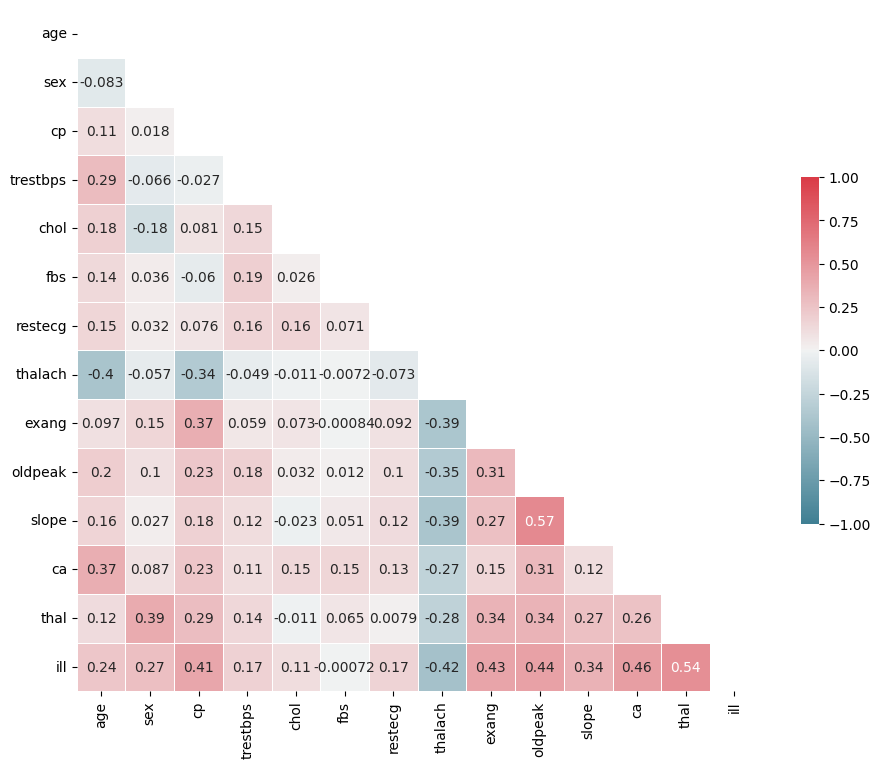

In [24]:
corr = df.corr()

mask = np.zeros_like(corr, dtype=bool)
mask[np.triu_indices_from(mask)] = True
cmap = sns.diverging_palette(220, 10, as_cmap=True)

fig, ax = plt.subplots(figsize=(11, 9))
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=1, vmin=-1, center=0,
            square=True, linewidths=.5, annot=True, cbar_kws={"shrink": .5})

# Exibir o mapa de calor (heatmap)
plt.show()

## 📏 **4.4 Scale Discrepancy Between Features**

Algorithms such as Logistic Regression, KNN, and SVM are sensitive to **differences in feature scale**. For instance:

- `age` may range from 30 to 80  
- `oldpeak` typically ranges from 0 to 6  
- `chol` may reach values above 300  

Such discrepancies can cause features with larger magnitudes to **dominate the learning process**, even if they are not more important. To address this, we applied **standardization using `StandardScaler`**, transforming numerical features to have **mean 0 and standard deviation 1**.

In [28]:
df['ill'].value_counts(normalize = True)

,proportion
ill,
0,0.534014
1,0.465986


## **Conclusion**

Data preparation is **as important as model training itself**. By ensuring the dataset is clean and well understood, we build a solid foundation for applying machine learning algorithms with greater **reliability, interpretability, and performance**.

# **5. MODEL TRAINING**
Given the relatively small size of the dataset (~300 records) and the **class imbalance** in the target variable, we will use a **stratified train-test split** to ensure that the distribution of classes is preserved in both training and testing sets. The test size will be set to **20%** (`test_size = 0.2`), providing a reasonable holdout set without sacrificing training data.

Each model will be trained on the stratified training set and evaluated on the test set using common classification metrics.

### **Parameter vs. Hyperparameter**

- **Parameters** are the internal coefficients or weights that the model learns from the training data (e.g., slopes in linear regression, split points in decision trees).
- **Hyperparameters** are the configuration values **set before** training begins (e.g., the number of neighbors in KNN, the depth of a decision tree, or the regularization strength in logistic regression).

In this initial step, we will evaluate the **baseline performance** of each model using **default hyperparameters**, without any tuning or optimization.


In [25]:
X = df.drop('ill', axis = 1)
y = df['ill']

In [26]:
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify = y, test_size = 0.2, random_state = 432)

## **5.1 LogisticRegression**
  - A linear model used for binary classification.
  - Estimates the probability of a class using a logistic (sigmoid) function.
  - Works well when the classes are linearly separable.

In [124]:
pipe_logistic = Pipeline([
    ('scaler', StandardScaler()),
    ('model', LogisticRegression())
])

In [125]:
pipe_logistic.fit(X_train, y_train)

Pipeline(steps=[('scaler', StandardScaler()), ('model', LogisticRegression())])

In [128]:
model_lr = pipe_logistic
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
recall_class_1 = make_scorer(recall_score, pos_label=1)
scores = cross_val_score(model_lr, X_train, y_train, cv=skf, scoring=recall_class_1)

print("Class 1 Recall per fold:", scores)
print("Class 1 Recall Mean:", scores.mean())
print("Recall Standard Deviation:", scores.std())

Class 1 Recall per fold: [0.81818182 0.77272727 0.95454545 0.77272727 0.68181818]
Class 1 Recall Mean: 0.8
Recall Standard Deviation: 0.0890723542830247


In [126]:
y_pred_logistic = pipe_logistic.predict(X_test)

In [127]:
print(classification_report(y_test, y_pred_logistic))

              precision    recall  f1-score   support

           0       0.87      0.84      0.86        32
           1       0.82      0.85      0.84        27

    accuracy                           0.85        59
   macro avg       0.85      0.85      0.85        59
weighted avg       0.85      0.85      0.85        59



##**5.2 Support Vector Classifier (SVC)**
  - A powerful algorithm that finds the optimal hyperplane to separate classes.
  - Effective in high-dimensional spaces and works well with clear margin separation.
  - Sensitive to feature scaling.

In [33]:
pipe_svc = Pipeline([
    ('scaler', StandardScaler()),
    ('model', SVC())
])

In [34]:
pipe_svc.fit(X_train, y_train)

Pipeline(steps=[('scaler', StandardScaler()), ('model', SVC())])

In [122]:
model_svc = pipe_svc
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
recall_class_1 = make_scorer(recall_score, pos_label=1)
scores = cross_val_score(model_svc, X_train, y_train, cv=skf, scoring=recall_class_1)

print("Class 1 Recall per fold:", scores)
print("Class 1 Recall Mean:", scores.mean())
print("Recall Standard Deviation:", scores.std())

Recall da classe 1 por fold: [0.81818182 0.72727273 0.81818182 0.72727273 0.68181818]
Média do recall da classe 1: 0.7545454545454545
Desvio padrão do recall: 0.05454545454545458


In [35]:
y_pred_svc = pipe_svc.predict(X_test)

In [36]:
print(classification_report(y_test, y_pred_svc))

              precision    recall  f1-score   support

           0       0.85      0.88      0.86        32
           1       0.85      0.81      0.83        27

    accuracy                           0.85        59
   macro avg       0.85      0.84      0.85        59
weighted avg       0.85      0.85      0.85        59



## **5.3 K-Nearest Neighbors (KNN)**
  - A non-parametric model that classifies a data point based on the majority label among its *k* nearest neighbors.
  - Sensitive to distance metrics and feature scales.
  - Simple and interpretable, but computationally expensive for large datasets.

In [37]:
pipe_knn = Pipeline([
    ('scaler', StandardScaler()),
    ('model', KNeighborsClassifier())
])

In [38]:
pipe_knn.fit(X_train, y_train)

Pipeline(steps=[('scaler', StandardScaler()),
                ('model', KNeighborsClassifier())])

In [121]:
model_knn = pipe_knn
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
recall_class_1 = make_scorer(recall_score, pos_label=1)
scores = cross_val_score(model_knn, X_train, y_train, cv=skf, scoring=recall_class_1)

print("Class 1 Recall per fold:", scores)
print("Class 1 Recall Mean:", scores.mean())
print("Recall Standard Deviation:", scores.std())

Recall da classe 1 por fold: [0.81818182 0.77272727 0.81818182 0.68181818 0.72727273]
Média do recall da classe 1: 0.7636363636363637
Desvio padrão do recall: 0.05300865358950276


In [39]:
y_pred_knn = pipe_knn.predict(X_test)

In [40]:
print(classification_report(y_test, y_pred_knn))

              precision    recall  f1-score   support

           0       0.83      0.91      0.87        32
           1       0.88      0.78      0.82        27

    accuracy                           0.85        59
   macro avg       0.85      0.84      0.84        59
weighted avg       0.85      0.85      0.85        59



## **5.4 Decision Tree**
- A tree-based model that splits the dataset into regions based on feature thresholds.
- Easy to interpret and visualize.
- Prone to overfitting if not properly controlled.

In [80]:
pipe_dt = Pipeline([
    ('model', DecisionTreeClassifier())
])

In [81]:
pipe_dt.fit(X_train, y_train)

Pipeline(steps=[('model', DecisionTreeClassifier())])

In [120]:
model_dt = pipe_dt
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
recall_class_1 = make_scorer(recall_score, pos_label=1)
scores = cross_val_score(model_dt, X_train, y_train, cv=skf, scoring=recall_class_1)

print("Class 1 Recall per fold:", scores)
print("Class 1 Recall Mean:", scores.mean())
print("Recall Standard Deviation:", scores.std())

Recall da classe 1 por fold: [0.86363636 0.68181818 0.59090909 0.68181818 0.59090909]
Média do recall da classe 1: 0.6818181818181818
Desvio padrão do recall: 0.09958591954639383


In [82]:
y_pred_dt = pipe_dt.predict(X_test)

In [83]:
print(classification_report(y_test, y_pred_dt))

              precision    recall  f1-score   support

           0       0.73      0.75      0.74        32
           1       0.69      0.67      0.68        27

    accuracy                           0.71        59
   macro avg       0.71      0.71      0.71        59
weighted avg       0.71      0.71      0.71        59



## **5.5 Random Forest**
  - An ensemble method that builds multiple decision trees and averages their predictions.
  - Reduces overfitting and improves generalization.
  - Handles unscaled data and feature interactions well.

In [114]:
pipe_rf = Pipeline([
    ('model', RandomForestClassifier())
])

In [115]:
pipe_rf.fit(X_train, y_train)

Pipeline(steps=[('model', RandomForestClassifier())])

In [118]:
model_rf = pipe_rf
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
recall_class_1 = make_scorer(recall_score, pos_label=1)
scores = cross_val_score(model_rf, X_train, y_train, cv=skf, scoring=recall_class_1)

print("Class 1 Recall per fold:", scores)
print("Class 1 Recall Mean:", scores.mean())
print("Recall Standard Deviation:", scores.std())

Recall da classe 1 por fold: [0.77272727 0.77272727 0.90909091 0.72727273 0.68181818]
Média do recall da classe 1: 0.7727272727272727
Desvio padrão do recall: 0.07606000241218869


In [116]:
y_pred_rf = pipe_rf.predict(X_test)

In [117]:
print(classification_report(y_test, y_pred_rf))

              precision    recall  f1-score   support

           0       0.87      0.84      0.86        32
           1       0.82      0.85      0.84        27

    accuracy                           0.85        59
   macro avg       0.85      0.85      0.85        59
weighted avg       0.85      0.85      0.85        59



## **5.6 XGBoost (Extreme Gradient Boosting)**
  - A highly efficient and scalable gradient boosting framework.
  - Builds additive trees sequentially to correct previous errors.
  - Includes regularization to prevent overfitting and handles missing values natively.

In [86]:
pipe_xgb = Pipeline([
    ('model', xgb.XGBClassifier())
])

In [87]:
pipe_xgb.fit(X_train, y_train)

Pipeline(steps=[('model',
                 XGBClassifier(base_score=None, booster=None, callbacks=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=None, device=None,
                               early_stopping_rounds=None,
                               enable_categorical=False, eval_metric=None,
                               feature_types=None, gamma=None, grow_policy=None,
                               importance_type=None,
                               interaction_constraints=None, learning_rate=None,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
                               max_depth=None, max_leaves=None,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, multi_strategy=None,
                               n_estimators=None, n_jobs=None,
                               num_parallel_tree=None, random_state=None, ...))])

In [119]:
model_xgb = pipe_xgb
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
recall_class_1 = make_scorer(recall_score, pos_label=1)
scores = cross_val_score(model_xgb, X_train, y_train, cv=skf, scoring=recall_class_1)

print("Class 1 Recall per fold:", scores)
print("Class 1 Recall Mean:", scores.mean())
print("Recall Standard Deviation:", scores.std())

Recall da classe 1 por fold: [0.81818182 0.81818182 0.77272727 0.72727273 0.63636364]
Média do recall da classe 1: 0.7545454545454546
Desvio padrão do recall: 0.06803013430498077


In [88]:
y_pred_xgb = pipe_xgb.predict(X_test)

In [89]:
print(classification_report(y_test, y_pred_xgb))

              precision    recall  f1-score   support

           0       0.78      0.78      0.78        32
           1       0.74      0.74      0.74        27

    accuracy                           0.76        59
   macro avg       0.76      0.76      0.76        59
weighted avg       0.76      0.76      0.76        59



## **Conclusion**

Working with clinical data, where false negatives (missed diagnoses) can have severe consequences, our priority is maximizing recall for class 1 (patients with illness). Below is an evaluation of six classification models based on this metric, using Stratified K-Fold Cross-Validation (k=5)

Best Performing Model(s):
 - **Logistic Regression**: performs well due to its ability to model linear relationships, and benefits from balanced data preprocessing and scaling.
    - Highest mean recall (0.80) across folds.
    - Reasonable standard deviation (0.089), indicating some variation, but performance is consistent with clinical importance.
 - **Random Forest**:
    - Slightly lower recall (0.77), but more stable (lower std).
    - Capable of capturing non-linearities and interactions, which is helpful in clinical datasets.

We also had a **surprisingly lower recall for XGBoost than RandomForest**, likely due to default hyperparameters not well-tuned for this dataset size/structure.

## **Following Steps**
We're going to proceed with hyperparameter optimization, especially for:
- **LogisticRegression**: to reduce variance
- **RandomForest**: to push recall slightly higher
- **XGBoost**: to unlock full potential.

# **6. Hyperparameters Optimization**
In this section, we will perform **hyperparameter tuning** to improve the performance and robustness of the pre-selected classification models.

Traditionally, one of the most common techniques for hyperparameter tuning is **Grid Search**, which exhaustively tests all possible combinations of hyperparameter values within a specified range. This approach can be **computationally expensive**, especially when the number of parameters or range of values is large.

To evaluate each combination of hyperparameters reliably, it's common to use **Cross-Validation** — a method that splits the training data into several folds (or subsets), trains the model on some folds and validates on the remaining. This allows us to assess the **generalization** of a model and detect overfitting or underfitting.

However, since our dataset is **small and imbalanced**, and since each model evaluation is relatively expensive, we will use a more efficient approach: **Bayesian Optimization**.


## **Why to use Bayesian Optimization**

- Builds a probabilistic model to estimate the performance of different hyperparameter combinations
- Chooses the next combination to test based on past performance
- Is **sample-efficient** and converges faster than Grid or Random Search
- Ensures each fold during validation maintains the same class distribution (using **StratifiedKFold**), which is crucial due to the **class imbalance**

Our focus will be on optimizing for **recall of class 1**, which represents patients diagnosed with heart disease.

This is a clinically sensitive context where reducing **false negatives** is a top priority — missing a sick patient can be much more dangerous than a false alarm.


## **6.1 LogisticRegression**

In [98]:
space_lr = [
    {
        'logisticregression__solver': Categorical(['lbfgs', 'newton-cg']),
        'logisticregression__penalty': Categorical(['l2']),
        'logisticregression__C': Real(0.001, 10, prior='log-uniform'),
        'logisticregression__max_iter': Integer(100, 300)
    },
    {
        'logisticregression__solver': Categorical(['liblinear']),
        'logisticregression__penalty': Categorical(['l1', 'l2']),
        'logisticregression__C': Real(0.001, 10, prior='log-uniform'),
        'logisticregression__max_iter': Integer(100, 300)
    }
]

pipe_lr = make_pipeline(StandardScaler(), LogisticRegression())

opt_lr = BayesSearchCV(
    estimator=pipe_lr,
    search_spaces=space_lr,
    n_iter=25,
    scoring='recall',
    cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=42),
    n_jobs=-1,
    random_state=42
)

In [99]:
opt_lr.fit(X_train, y_train)

BayesSearchCV(cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=True),
              estimator=Pipeline(steps=[('standardscaler', StandardScaler()),
                                        ('logisticregression',
                                         LogisticRegression())]),
              n_iter=25, n_jobs=-1, random_state=42, scoring='recall',
              search_spaces=[{'logisticregression__C': Real(low=0.001, high=10, prior='log-uniform', transform='normalize'),
                              'logistic...
                              'logisticregression__solver': Categorical(categories=('lbfgs', 'newton-cg'), prior=None)},
                             {'logisticregression__C': Real(low=0.001, high=10, prior='log-uniform', transform='normalize'),
                              'logisticregression__max_iter': Integer(low=100, high=300, prior='uniform', transform='normalize'),
                              'logisticregression__penalty': Categorical(categories=('l1', 'l2'), prior=None),
                              'logisticregression__solver': Categorical(categories=('liblinear',), prior=None)}])

In [100]:
best_lr = opt_lr.best_estimator_

In [140]:
model_lr = best_lr
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
recall_class_1 = make_scorer(recall_score, pos_label=1)
scores = cross_val_score(model_lr, X_train, y_train, cv=skf, scoring=recall_class_1)

print("Class 1 Recall per fold:", scores)
print("Class 1 Recall Mean:", scores.mean())
print("Recall Standard Deviation:", scores.std())

Class 1 Recall per fold: [0.90909091 0.86363636 0.90909091 0.63636364 0.72727273]
Class 1 Recall Mean: 0.809090909090909
Recall Standard Deviation: 0.10909090909090909


In [101]:
y_pred_lr = best_lr.predict(X_test)

In [102]:
print(classification_report(y_test, y_pred_lr))

              precision    recall  f1-score   support

           0       0.89      0.78      0.83        32
           1       0.77      0.89      0.83        27

    accuracy                           0.83        59
   macro avg       0.83      0.84      0.83        59
weighted avg       0.84      0.83      0.83        59



## **6.2 Random Forest**

In [141]:
space_rf = {
    'randomforestclassifier__n_estimators': Integer(50, 300),
    'randomforestclassifier__max_depth': Integer(3, 20),
    'randomforestclassifier__min_samples_split': Integer(2, 10),
    'randomforestclassifier__min_samples_leaf': Integer(1, 5),
    'randomforestclassifier__bootstrap': Categorical([True, False])
}

pipe_rf = make_pipeline(RandomForestClassifier(random_state=42))

opt_rf = BayesSearchCV(
    estimator=pipe_rf,
    search_spaces=space_rf,
    n_iter=25,
    scoring='recall',
    cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=42),
    n_jobs=-1,
    random_state=42
)

In [142]:
opt_rf.fit(X_train, y_train)

BayesSearchCV(cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=True),
              estimator=Pipeline(steps=[('randomforestclassifier',
                                         RandomForestClassifier(random_state=42))]),
              n_iter=25, n_jobs=-1, random_state=42, scoring='recall',
              search_spaces={'randomforestclassifier__bootstrap': Categorical(categories=(True, False), prior=None),
                             'randomforestclassifier__max_...prior='uniform', transform='normalize'),
                             'randomforestclassifier__min_samples_leaf': Integer(low=1, high=5, prior='uniform', transform='normalize'),
                             'randomforestclassifier__min_samples_split': Integer(low=2, high=10, prior='uniform', transform='normalize'),
                             'randomforestclassifier__n_estimators': Integer(low=50, high=300, prior='uniform', transform='normalize')})

In [143]:
best_rf = opt_rf.best_estimator_

In [146]:
model_rf = best_rf
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
recall_class_1 = make_scorer(recall_score, pos_label=1)
scores = cross_val_score(model_rf, X_train, y_train, cv=skf, scoring=recall_class_1)

print("Class 1 Recall per fold:", scores)
print("Class 1 Recall Mean:", scores.mean())
print("Recall Standard Deviation:", scores.std())

Class 1 Recall per fold: [0.86363636 0.81818182 0.90909091 0.72727273 0.68181818]
Class 1 Recall Mean: 0.8
Recall Standard Deviation: 0.08430562268632459


In [144]:
y_pred_rf = best_rf.predict(X_test)

In [163]:
print(classification_report(y_test, y_pred_rf))

              precision    recall  f1-score   support

           0       0.87      0.84      0.86        32
           1       0.82      0.85      0.84        27

    accuracy                           0.85        59
   macro avg       0.85      0.85      0.85        59
weighted avg       0.85      0.85      0.85        59



## **6.3 XGBoost**

In [156]:
pipe_xgb = Pipeline([
    ('xgb', xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42))
])

# Espaço de busca para hiperparâmetros do XGBoost
search_space = {
    'xgb__n_estimators': Integer(50, 300),
    'xgb__max_depth': Integer(2, 10),
    'xgb__learning_rate': Real(0.01, 0.3, prior='log-uniform'),
    'xgb__subsample': Real(0.5, 1.0),
    'xgb__colsample_bytree': Real(0.5, 1.0),
    'xgb__gamma': Real(0, 5),
    'xgb__reg_lambda': Real(0.1, 10, prior='log-uniform'),
    'xgb__reg_alpha': Real(0.1, 10, prior='log-uniform')
}

# Validação cruzada estratificada (5 folds)
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Otimizador Bayesiano
opt_xgb = BayesSearchCV(
    estimator=pipe_xgb,
    search_spaces=search_space,
    n_iter=50,  # pode aumentar para melhor resultado
    cv=cv,
    scoring='recall',  # foco no recall da classe positiva (classe 1)
    n_jobs=-1,
    verbose=0,
    random_state=42
)

In [157]:
opt_xgb.fit(X_train, y_train)

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [16:03:41] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


BayesSearchCV(cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=True),
              estimator=Pipeline(steps=[('xgb',
                                         XGBClassifier(base_score=None,
                                                       booster=None,
                                                       callbacks=None,
                                                       colsample_bylevel=None,
                                                       colsample_bynode=None,
                                                       colsample_bytree=None,
                                                       device=None,
                                                       early_stopping_rounds=None,
                                                       enable_categorical=False,
                                                       eval_metric='logloss',
                                                       feature_types=None,
                                                       gamma=None,
                                                       gr...
                             'xgb__max_depth': Integer(low=2, high=10, prior='uniform', transform='normalize'),
                             'xgb__n_estimators': Integer(low=50, high=300, prior='uniform', transform='normalize'),
                             'xgb__reg_alpha': Real(low=0.1, high=10, prior='log-uniform', transform='normalize'),
                             'xgb__reg_lambda': Real(low=0.1, high=10, prior='log-uniform', transform='normalize'),
                             'xgb__subsample': Real(low=0.5, high=1.0, prior='uniform', transform='normalize')})

In [160]:
model_xgb = opt_xgb
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
recall_class_1 = make_scorer(recall_score, pos_label=1)
scores = cross_val_score(model_xgb, X_train, y_train, cv=skf, scoring=recall_class_1)

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [16:07:57] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [16:10:24] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [16:12:59] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [16:15:43] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [16:18:23] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_e

In [161]:
print("Class 1 Recall per fold:", scores)
print("Class 1 Recall Mean:", scores.mean())
print("Recall Standard Deviation:", scores.std())

Class 1 Recall per fold: [0.86363636 0.77272727 0.81818182 0.68181818 0.63636364]
Class 1 Recall Mean: 0.7545454545454545
Recall Standard Deviation: 0.0843056226863246


In [158]:
y_pred = opt_xgb.predict(X_test)

In [162]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.90      0.84      0.87        32
           1       0.83      0.89      0.86        27

    accuracy                           0.86        59
   macro avg       0.86      0.87      0.86        59
weighted avg       0.87      0.86      0.86        59



## **📊 Models Comparison**

### **1. Logistic Regression**
  - Achieved **excellent test performance (0.89)**.
  - High variance in cross-validation folds, suggesting potential instability across subsets.
  - Strong generalization when properly regularized and scaled.
  - Performs well with linear patterns and clean datasets.

### **2. Random Forest**
  - Strong and **consistent performance** across folds.
  - Slightly lower than Logistic Regression in CV mean, but more reliable.
  - Handles non-linearities and feature interactions effectively.
  - Excellent robustness, making it highly suitable for clinical scenarios.

### **3. XGBoost**
  - Slightly underperformed during CV, but **achieved top performance on test set (0.89)**.
  - Indicates the ability to capture complex patterns, possibly overfitting slightly on training folds.
  - Very competitive model; if test data is representative of future unseen data, this is a **strong candidate**.


## **Conclusion**
Each model captured different patterns and contributed uniquely to performance. To **take advantage of their complementary strengths**, we will now apply an **ensemble method**, combining their predictions.

This strategy is designed to **enhance robustness, reduce variance**, and ideally improve the model's ability to **generalize to unseen data** — all while maintaining high sensitivity (recall) for detecting true positive cases.

## **Following Steps**

A **VotingClassifier (soft voting)** combining:
- `LogisticRegression (optimized)`
- `RandomForest (optimized)`
- `XGBoost (optimized)`

#**7. Model Ensemble**

## **Soft Voting for Model Ensemble**

Soft voting is an ensemble technique where multiple classifiers contribute to the final prediction based on the **probabilities** they assign to each class. Unlike hard voting—which simply counts the final class predictions of each model—soft voting **averages the predicted probabilities** for each class across all models and selects the class with the highest average probability.

This allows the ensemble to consider how confident each model is in its predictions, not just which class they choose, and fit our project's needs because of:

1. **Probability Awareness**  
   In a clinical setting, the difference between a 51% and a 95% probability of disease is critical. Soft voting incorporates these confidence levels into the final decision, making it a **more nuanced and informative** approach than majority voting.

2. **Reducing Risk of False Negatives**  
   Because our priority is to **identify all potential positive cases (sick patients)**, we benefit from models that express **strong confidence in class 1 predictions**. Soft voting amplifies these confidence signals and helps to **reduce false negatives**, which is a key objective in medical diagnostics.

3. **Combining Complementary Strengths**  
   After hyperparameter tuning, we observed that different models showed different strengths (e.g., one with higher recall, another with better overall accuracy). Soft voting allows us to **combine these strengths**, especially when models are well-calibrated.

4. **Interpretability and Clinical Trust**  
   Probabilistic outputs provided by soft voting are more interpretable in clinical contexts, where **risk stratification** and **shared decision-making with patients** are important.

In [166]:
voting_soft = VotingClassifier(estimators = [('lr', model_lr), ('rf', model_rf), ('xgb', model_xgb)], voting = 'soft')
voting_soft.fit(X_train, y_train)

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [17:24:35] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


VotingClassifier(estimators=[('lr',
                              Pipeline(steps=[('standardscaler',
                                               StandardScaler()),
                                              ('logisticregression',
                                               LogisticRegression(C=0.06538994719950007,
                                                                  max_iter=294,
                                                                  penalty='l1',
                                                                  solver='liblinear'))])),
                             ('rf',
                              Pipeline(steps=[('randomforestclassifier',
                                               RandomForestClassifier(bootstrap=False,
                                                                      max_depth=18,
                                                                      min_samples_leaf=2,
                                                                      min_samples_split=10,
                                                                      n_estimato...
                                                           'xgb__max_depth': Integer(low=2, high=10, prior='uniform', transform='normalize'),
                                                           'xgb__n_estimators': Integer(low=50, high=300, prior='uniform', transform='normalize'),
                                                           'xgb__reg_alpha': Real(low=0.1, high=10, prior='log-uniform', transform='normalize'),
                                                           'xgb__reg_lambda': Real(low=0.1, high=10, prior='log-uniform', transform='normalize'),
                                                           'xgb__subsample': Real(low=0.5, high=1.0, prior='uniform', transform='normalize')}))],
                 voting='soft')

In [167]:
model_soft_voting = voting_soft
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
recall_class_1 = make_scorer(recall_score, pos_label=1)
scores = cross_val_score(model_soft_voting, X_train, y_train, cv=skf, scoring=recall_class_1)

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [17:29:06] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [17:31:32] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [17:34:08] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [17:36:53] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [17:39:37] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_e

In [168]:
print("Class 1 Recall per fold:", scores)
print("Class 1 Recall Mean:", scores.mean())
print("Recall Standard Deviation:", scores.std())

Class 1 Recall per fold: [0.86363636 0.81818182 0.86363636 0.68181818 0.63636364]
Class 1 Recall Mean: 0.7727272727272727
Recall Standard Deviation: 0.09534625892455925


In [172]:
y_pred = model_soft_voting.predict(X_test)

In [173]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.90      0.84      0.87        32
           1       0.83      0.89      0.86        27

    accuracy                           0.86        59
   macro avg       0.86      0.87      0.86        59
weighted avg       0.87      0.86      0.86        59



#**8. Conclusion**

We trained and evaluated multiple classifiers — including Logistic Regression, Random Forest, and XGBoost — using:

- **Bayesian optimization with cross-validation** to fine-tune hyperparameters.
- **Stratified K-Fold Cross-Validation (5 folds)** to ensure robustness and fair distribution of the target classes.
- A **held-out test set** to simulate real-world model performance.

After individual model optimization, a **Soft Voting Classifier** was built by combining the three top models (`LogisticRegression`, `RandomForest`, and `XGBoost`) to leverage their complementary strengths.



### **Performance Comparison (Test Set)**

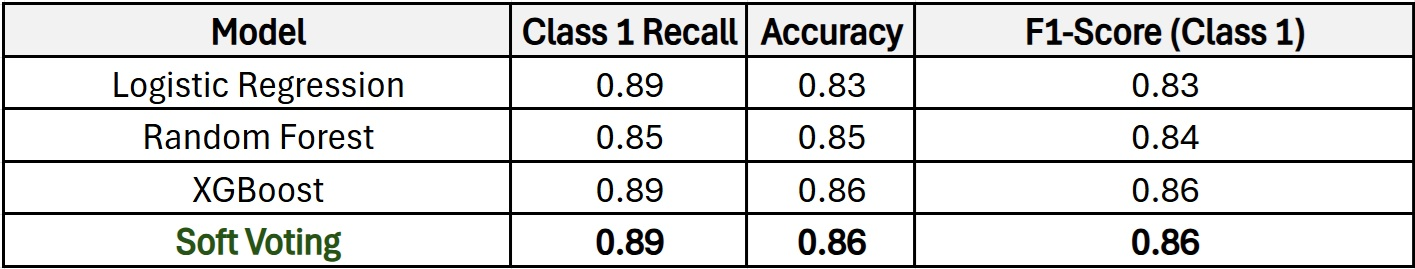

All models performed well, but **Soft Voting matched the highest class 1 recall (0.89)** while combining the advantages of all three algorithms.


### **Cross-Validation Results (Class 1 Recall)**

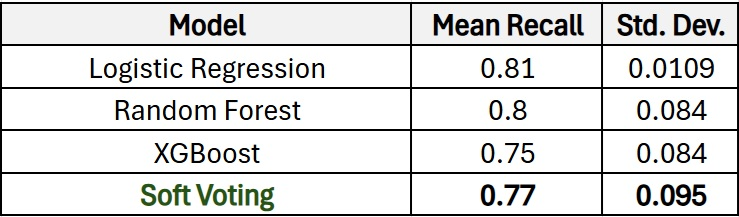

It is important to note that although Logistic Regression achieved the highest mean class 1 recall in cross-validation, and Soft Voting did not outperform it in that context, **Soft Voting demonstrated more balanced and stable performance** in the test set. The standard deviation of 0.095 in Soft Voting's cross-validation recalls indicates a moderate variation between folds, which was comparable to the individual models.

These findings were carefully considered, and we concluded that the **ideal final model should be the one that consistently maintains high class 1 recall in production**, i.e., on unseen test data — where Soft Voting showed strong performance.

Taking all these factors into account — including test set performance, model complementarity, and validation robustness — the **Soft Voting Classifier** was selected as the final model to move forward, as it is the most aligned with the project's **clinical safety and predictive goals**.

#**9. Exporting Model**

In [175]:
joblib.dump(model_soft_voting, 'model_HD.pkl')

['model_HD.pkl']